In [48]:
import networkx as nx
import numpy as np
from sklearn.cluster import KMeans
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
#from karateclub import Node2Vec
from src.helper import draw_spring, load_graph_from_json, dataframe_from_results
np.random.seed(123)

# 4 Community Detection

The detection of communities is crucial for drawing insights from networks. Networks can be highly complex, often spanning hundreds, thousands, or even millions of node. Grouping (clustering) nodes together is one way to identify possible patterns. Clusters may be consist of social actors that are more closely tied and interact more frequently than the rest of the network (and then perhaps literally communities), they may reveal similarities in meaning, or clusters can indicate how precedents relate.

For example, if one looks at a case citation or case similarity netowrk of 200,000 nodes, it would be a gain if one could group that complexity into, say, 8 communities. These communities might show a common similarity between these cases, for example that they focus on causality, the right to a fair trial, apologies, whistleblower cases, traffic accidents, etc. These communites might also point towards the case law's genealogy in terms of precedents. Combined with centrality measures, community detection allows zooming in on specific clusters, identifying central cases within clusters of decisions in addition to the network as a whole, to find communities within communities, or to analyze over time which groups of nodes were clustered when (or were no longer clustered).

Sometimes communities will be visible to the naked eye, as we can see here with an example of the barbell graph. This is a form of graph that two obvious communities in the "plates" of the barbell joined together by a number of nodes (in the case below 3) that form the metal shaft.

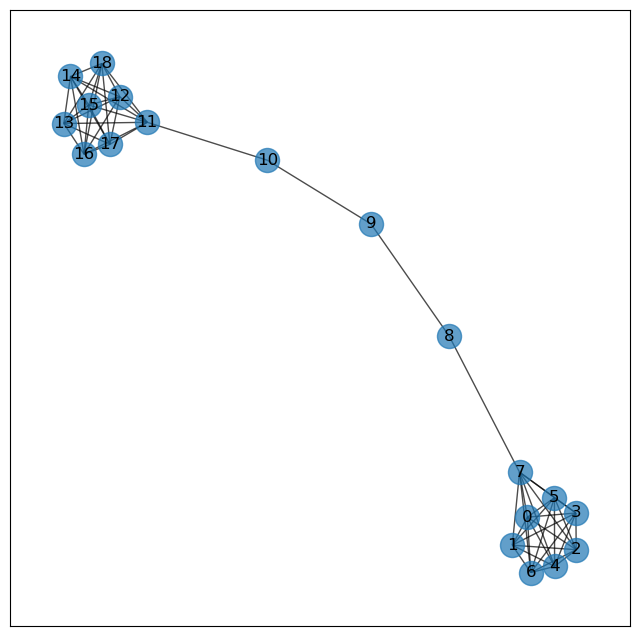

In [12]:
g_barbell = nx.barbell_graph(8, 3)
draw_spring(g_barbell)

It should be obvious at this point that in most scenarios it will not be possible to detect communities just by looking. Networks are often too complex. Community detection methods can assist in unraveling the complexity. In this discussion we will explore two approches:

* Clustering on network embeddings.
* Network algorithms.

What both of these concepts mean will be explained in turn.

## 4.1  Clustering on Network Embeddings

One way to find communities is to use clustering methods on an "embedding" of the network. Clustering here needs to be taken in the wide sense as any machine learning method that identifies groups or clusters of data points. This can be striclty speaking a clustering method (as in the case of KMeans which we see below) or some other machine learning technique.

In order to use machine learning techniques, however, a network embedding is needed. An embedding is a mathematical representation of the network that captures spatial information (node 1 neighbors with node 2, and node 2 with node 3 and 4, etc) in a tabular two dimensional format where every row is an observation and every column is a feature.

Network embeddings are very useful because by changing the network into a tabular format they enable the use of any machine learning model on the network. For community detection this will normally be a form of unsupervised learning where the algorithm identifies labels (in this case community labels) in unlabelled data, other approaches are possible. For example one could label certain nodes, and then ask an algorithm to put labels on nodes that are similar to them, changing the approach from unsupervised to supervised or semi-supervised (depending on how thorough the labeling is).

This tabular format may be one we are very used to by now, but it is good to bring this to mind by presenting the first 10 rows of a classic dataset. You can see here that every row is an observation, and that every column is a feature (or variable). For more insights on such tabular formats see Crawley (2014).

In [13]:
iris = sns.load_dataset("iris")
iris.head(10)

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa
5,5.4,3.9,1.7,0.4,setosa
6,4.6,3.4,1.4,0.3,setosa
7,5.0,3.4,1.5,0.2,setosa
8,4.4,2.9,1.4,0.2,setosa
9,4.9,3.1,1.5,0.1,setosa


The most common unsupervised learning algorithm is KMeans clustering and that is what we will focus on here.

Regarding network embeddings, this section will consider the adjacency matrix, the laplacian matrix and the eigenvectors associated with a certain number of smallest non-zero eigenvalues. These are all called embeddings here insfoar they constitute a matheamtical representation of the network. Not all of them are equally good. As we will see, some of these representations lead to unsatisfactory results. But the concept of embeddings is best understood in the progression from the adjacency matrix to more complex representations (neural networks can also be used to create embeddings for networks, in process that is similar as creating word embeddings from text, but they will not be considered here).

The recurring example will be the classification of the two factions of Zachary's 'karate club' network (1977). We have used this graph before in Chapter 3, and there we used centrality measures to identify the President and the Instructor of the club, on the hyopthesis that they would be the most well connected nodes in the graph (which proves to be true). Now we will use communities to address Zachary's actual research question: how the group will split up? Who will go with the President and who will go with the Instructor. (Zachary used Maximum Flow Cut Labelling, but we will use newer methods that have perhaps more general interest).

Recall that in the networkx version of the dataset, the president is node 0, and the karate instructor node 33. 


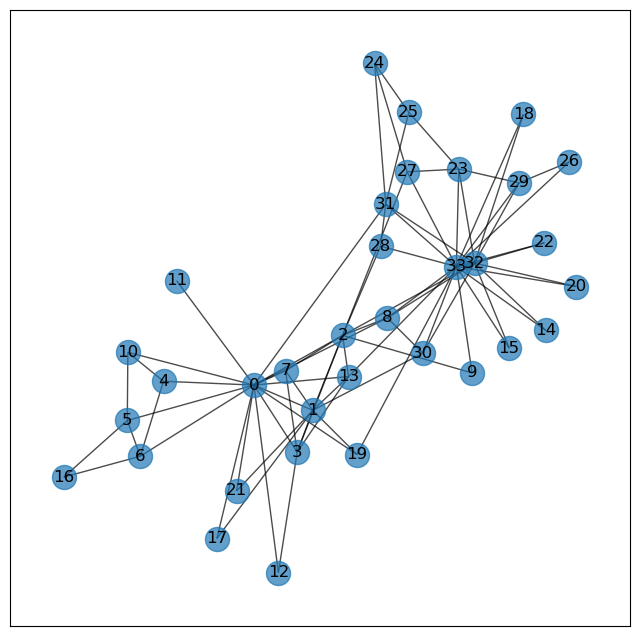

In [14]:
g_karate = nx.karate_club_graph()
draw_spring(g_karate)

### A. KMeans clustering

KMeans requires that one has an idea of how many clusters we should end up with when running the algorithm. The $K$ in KMeans Kmeans clustering refers to the number of clusters. So if one thinks there are 2 clusters, then $k = 2$, if one thinks there are 3 clusters, $ k = 3$ and so on. There are ways to use some statistical metrics to identy the "optimal" number for k, but these are outside the scope of our analysis. The Karate club split into two groups, so we know that for us $k$ must mean 2 ("optimal" is in quotes, because these metrics are indicative of a good fit, but not decisive; domain knowledge is also required to identify the most reasonable number of clusters).

There are many versions of tke KMeans algorithm, what we are going to present here is a simple, naive version of it. In this verison the only goal of the K-means clustering technique is to partition space so as to minimize the sum of sqaured residuals ($SSR$) from the hipothesized mean within the assumed set of clusters.

The target of KMeans is defined as:

$$ argmin\big(\sum_i^k \sum (x - \mu)^2\big) $$

This formula has two $\Sigma$ sum operators one after another. Like in other formulas, the precedence is first inner, then outer. So the first sum operator needs to be understood first. This operator is precisely the sum of squared residuals or $SSR$.

$$ SSR =  \sum (x - \mu)^2 $$

$SSR$ may be familiar to you from other contexts. It is a prior step to calculating variance and standard deviation. $x$ here is any data point within a hypothesized cluster, and $\mu$ is the mean of that cluster. What the difference $x-\mu$ does is to take the distance between x and the mean. This is then squared. Squaring here is used mainly to enusre that all values are positive (if x is lesser than the mean, $x-\mu$ will give you a negative value, but this is not necessary for calculating distance. If all we care about is how long it takes to get from here ($x$) to there ($\mu$) it does not matter if we are to the East of $\mu$ or to the West of $\mu$).

This $SSR$ calculation is to be done for every cluster. This is represented by the outer sum that goes from 1 (the first cluster) to k (the last cluster). The target is to miminize, to find the smallest value possible, for $SSR$ summed accross all the hypothesized clusters. To explain that we want to minimze we just put $argmin$ as a function over the whole equation. 

$$ argmin\big(\sum_1^k \sum (x - \mu)^2\big) $$

The algorithm proceeds to find this value using an iterative process that is roughly described as follows:

1) First hypothesizing a mean for each of the cluster randomly.
2) Assigning each data point to the mean that is closest to it
3) Measuring the real mean of the cluster and its SSR score
4) Repeat from point 2...
5) Until the custer centers do not change any more or some other specified condition is met.

Below we can see KMeans in action in the iris dataset that presented above. This dataset presents you with already known classifications of the species of iris flower: setosa, versicolor and virginica. But lets imagine that while we know that there are three types of iris flowers in the dataset we do not have the labels to begin with, and that we want to use KMeans to know which data point is likely to belong to each species. So we will use the KMeans algorithm to guess this values, with $k=3$.

Here we will run the algorithm in verbose form to see how the target function decreases with each step. Convergence here means that after iteration 3, the cluster centers do not change. 

In [15]:
km = KMeans(n_clusters=3, verbose=True, n_init=1).fit(iris.drop("species", axis=1))
predictions = km.predict(iris.drop("species", axis=1))


Initialization complete
Iteration 0, inertia 136.43.
Iteration 1, inertia 79.20444108199493.
Iteration 2, inertia 78.85144142614601.
Converged at iteration 2: strict convergence.


As we can see from the plot below, it reaches a very good match to the actual taxonomic classification in just 4 iterations.

<Axes: xlabel='petal_length', ylabel='petal_width'>

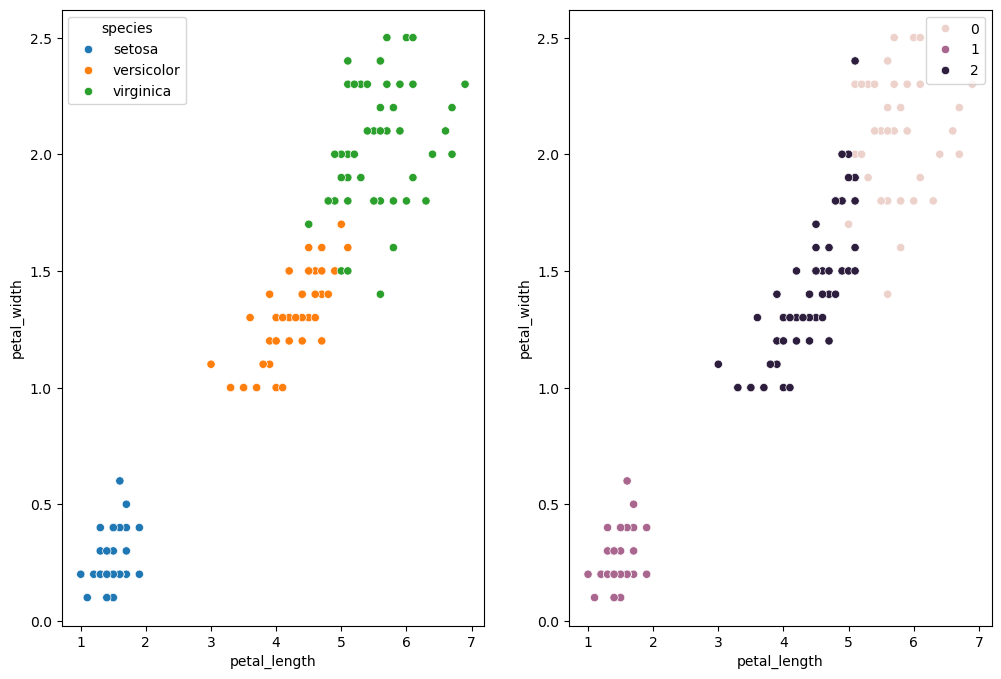

In [16]:
fig, ax = plt.subplots(1, 2, figsize=(12, 8))
sns.scatterplot(data=iris, x="petal_length", y="petal_width", hue="species", ax = ax[0])
sns.scatterplot(data=iris, x="petal_length", y="petal_width", hue=predictions, ax = ax[1])

### B. Clustering on the adjacency matrix and the laplacian matrix

Now lets try to get the two groups using KMeans clustering on the adjacency matrix and the laplacian matrix, which are our first naive embeddings of the graph. 

The adjacency matrix, records the edges between the nodes. So a 1 here means a link from a node to another and a 0 none (this was explained in more detail in section 3.3). 

$$ A = \pmatrix{
0 & 1 & 1 & 0 \\ 
1 & 0 & 1 & 1 \\ 
1 & 1 & 0 & 1 \\ 
0 & 1 & 1 & 0 \\ 
} $$

The degree matrix records the degree of every node in the diagonal and has zeros otherwise.

$$ D = \pmatrix{
2 & 0 & 0 & 0 \\ 
0 & 3 & 0 & 0 \\ 
0 & 0 & 3 & 0 \\ 
0 & 0 & 0 & 2 \\ 
} $$

Using these two matrices we can find the Laplacian matrix by simply subtracting the adjacency matrix from the degree matrix, so 

$$ L = D-A $$

Substraction of matrices is basic arithmetic, it just means elementwise substractions, so we do (for the first row:) 2-0, 0-1, 0-1, 0-0, and so forth until we get:

$$ L = \pmatrix{
2 & -1 & -1 & 0 \\ 
-1 & 3 & -1 & -1 \\ 
-1 & -1 & 3 & -1 \\ 
0 & -1 & -1 & 2 \\ 
} $$

Naturally the arithmetic involved in this will be practically impossible for humans on any matrix of reasonable size. Software can just give you the Laplacian matrix of a graph on command.

Using either the adjacecny matrix or the graph matrix does not succeed. The president (node 0) and the karate instructor (33) are put in different groups, but the students are not correctly classified in their respective clicques.

Arguably the reason this does not work is that the adjacency matrix and the laplacian matrix are poor representations of the graph for machine learning. While the network can be reconstructed from these matrices, from a machine learning perspective all that these representations record is the neighbors that are one jump away from each other, and degree infomration if it is a laplacian matrix. 

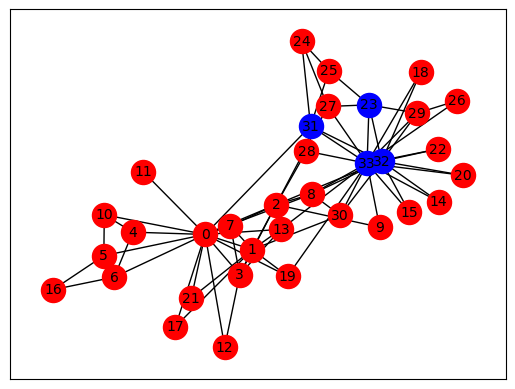

In [17]:
g_karate = nx.karate_club_graph()
M = nx.adjacency_matrix(g_karate).todense()

km = KMeans(2)
res = km.fit_predict(M)

reszero = np.where(res==0)[0].tolist()
resone = np.where(res==1)[0].tolist()

pos = nx.spring_layout(g_karate, seed=123)
nx.draw_networkx_nodes(g_karate, pos = pos, nodelist=reszero, node_color="blue")
nx.draw_networkx_nodes(g_karate, pos = pos, nodelist=resone, node_color="red")
nx.draw_networkx_edges(g_karate, pos = pos)
nx.draw_networkx_labels(g_karate, pos = pos, font_size=10);

The results are worse if we use the laplacian matrix.

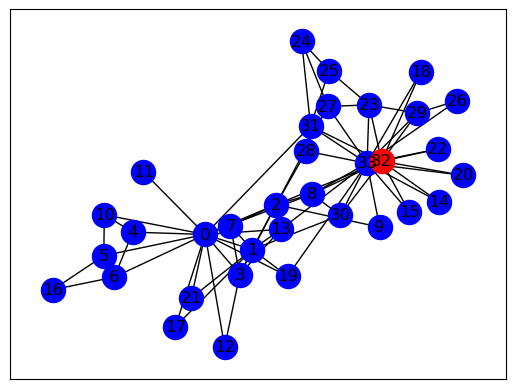

In [18]:
M = nx.laplacian_matrix(g_karate).todense()


km = KMeans(2)
res = km.fit_predict(M)

reszero = np.where(res==0)[0].tolist()
resone = np.where(res==1)[0].tolist()

pos = nx.spring_layout(g_karate, seed=123)
nx.draw_networkx_nodes(g_karate, pos = pos, nodelist=reszero, node_color="blue")
nx.draw_networkx_nodes(g_karate, pos = pos, nodelist=resone, node_color="red")
nx.draw_networkx_edges(g_karate, pos = pos)
nx.draw_networkx_labels(g_karate, pos = pos);

### C. Spectral clustering


The problem with the above attempt is that the adjacency matrix and the laplacian matrix are not good network embeddings for the purposes of clustering. They fail to represent "what is going on" inside the network. 

A better approach would be spectral clustering. Here isntead of using either one of the aforementioned matrixes, we apply clustering to certain mathematic properties that arise from the laplacian matrix, through so-called spectral decomposition. 

First we need the laplacian matrix of the karate club graph.

In [19]:
laplacian_karate = nx.laplacian_matrix(g_karate)

The next step is to find the eigenvector associated with the n smallest non-zero eigenvalues. The n depends on how many clusters you want. If you want two clusters, you need to look for the smallest eigenvector. If you want three clusters, you select the two smallest, and so on.

Let us print a list of eigenvalues (obtained with Numpy). Note that there are 34 eigenvalues, one for each node in the Karate club network example.

In [20]:
# this get us the values and the vectors
vals, vecs = np.linalg.eig(laplacian_karate.todense())
# here we extract the values
vals

array([5.20653410e+01, 4.59907681e+01, 4.18328632e+01, 3.79927558e+01,
       2.96883840e+01, 2.55555039e+01, 2.27849630e+01, 2.13586504e+01,
       1.93238240e+01, 1.70337951e+01, 1.48885752e+01, 1.43813508e+01,
       1.20754027e+01, 1.18744202e+01, 3.45489264e-15, 1.02218147e+01,
       1.00106981e+01, 9.18096651e+00, 1.18710730e+00, 6.97788032e+00,
       6.44605541e+00, 5.59481244e+00, 2.39431926e+00, 5.16855490e+00,
       4.97817925e+00, 4.69727550e+00, 4.54469763e+00, 4.16160574e+00,
       3.70606484e+00, 3.80094429e+00, 2.93182048e+00, 2.96830180e+00,
       3.12126310e+00, 3.06104079e+00])

Lets sort the values to make it easier to spot the second smallest eigenvalue.

In [21]:
np.sort(vals)

array([3.45489264e-15, 1.18710730e+00, 2.39431926e+00, 2.93182048e+00,
       2.96830180e+00, 3.06104079e+00, 3.12126310e+00, 3.70606484e+00,
       3.80094429e+00, 4.16160574e+00, 4.54469763e+00, 4.69727550e+00,
       4.97817925e+00, 5.16855490e+00, 5.59481244e+00, 6.44605541e+00,
       6.97788032e+00, 9.18096651e+00, 1.00106981e+01, 1.02218147e+01,
       1.18744202e+01, 1.20754027e+01, 1.43813508e+01, 1.48885752e+01,
       1.70337951e+01, 1.93238240e+01, 2.13586504e+01, 2.27849630e+01,
       2.55555039e+01, 2.96883840e+01, 3.79927558e+01, 4.18328632e+01,
       4.59907681e+01, 5.20653410e+01])

Note that numpy will often give you very small numbers which are equivalent to zero. Here the first number is practically a zero. We can see this if we round the numbers to, say, 5 decimal places.

In [22]:
np.sort(np.round(vals,5))

array([ 0.     ,  1.18711,  2.39432,  2.93182,  2.9683 ,  3.06104,
        3.12126,  3.70606,  3.80094,  4.16161,  4.5447 ,  4.69728,
        4.97818,  5.16855,  5.59481,  6.44606,  6.97788,  9.18097,
       10.0107 , 10.22181, 11.87442, 12.0754 , 14.38135, 14.88858,
       17.0338 , 19.32382, 21.35865, 22.78496, 25.5555 , 29.68838,
       37.99276, 41.83286, 45.99077, 52.06534])

Now we can see that the smallest non-zero eigenvalue is 1.18710730e+00. To avoid human errors with counting, we can use ````np.where```` to find its position.

It tells us that it is the position 18 in the array.

In [23]:
# because python indexes start at 0, indexing at 1 will give us the second smallest value.
smallest_non_zero = np.sort(vals,)[1]
np.where(vals==smallest_non_zero)

(array([18]),)

Which we can confirm as true

In [24]:
vals[18]

np.float64(1.1871073019962124)

Now we need to get the eigenvector associated with the smallest non-zero eigenvalue, which is the eigenvector in position 18. Here we just need to index into the 18th column (counting from zero) of the eigenvector variable.

In [25]:
X = vecs[:,18]
X = np.asarray(X)
X

array([ 0.1233171 ,  0.0580066 ,  0.01368446,  0.07445083,  0.26733837,
        0.29881441,  0.29744558,  0.06406144, -0.0530052 , -0.12925543,
        0.28550172,  0.20406685,  0.12324309,  0.03493189, -0.17156602,
       -0.15520216,  0.37166422,  0.16804128, -0.21148231,  0.0625882 ,
       -0.18847412,  0.1289233 , -0.16858175, -0.14801794, -0.15762212,
       -0.14632034, -0.19249255, -0.12982346, -0.09449019, -0.16960883,
       -0.08368282, -0.1170647 , -0.13538405, -0.12400534])

Having this, we can cluster them using KMeans. In our case, we select two clusters because we know from the paper by Zachary that the group would split into two.

In order to run KMeans first we need to turn the array X into a two dimensional array using the reshape method, as sklearn expects this type of data. 

One can be easily confused here, because the result will be only one column and this may appear to be one dimensional, but numpy and scikit-learn treat differently one dimensional arrays that are just sequences of numbers where no discrimination is made to something being a row or a column, and two dimensional arrays which can be of one ror only, or of one column only, but remain two dimensional insofar they differntiate rows and columns. In other words, a one dimensional array does not specify if the array is a row or a column. A two dimensional array will specify if it is a row or a column, even if it has only one row or only one column. In this sense it is "two dimensional".

In [26]:
print(X.shape)
# the -1 here says "give me as many rows as necessary", the 1 says "and just one column"
X = X.reshape(-1,1)
print(X.shape)

(34,)
(34, 1)


Before running KMeans, if we inspect the vector visually we may see that it is possible to see two clusters, one of positive signed numbers and one of positive signed numbers.

In [27]:
np.sort(X, axis=0)

array([[-0.21148231],
       [-0.19249255],
       [-0.18847412],
       [-0.17156602],
       [-0.16960883],
       [-0.16858175],
       [-0.15762212],
       [-0.15520216],
       [-0.14801794],
       [-0.14632034],
       [-0.13538405],
       [-0.12982346],
       [-0.12925543],
       [-0.12400534],
       [-0.1170647 ],
       [-0.09449019],
       [-0.08368282],
       [-0.0530052 ],
       [ 0.01368446],
       [ 0.03493189],
       [ 0.0580066 ],
       [ 0.0625882 ],
       [ 0.06406144],
       [ 0.07445083],
       [ 0.12324309],
       [ 0.1233171 ],
       [ 0.1289233 ],
       [ 0.16804128],
       [ 0.20406685],
       [ 0.26733837],
       [ 0.28550172],
       [ 0.29744558],
       [ 0.29881441],
       [ 0.37166422]])

Or more visually...

<Axes: >

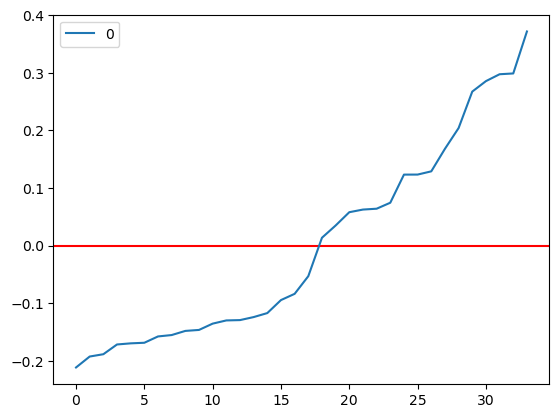

In [28]:
plt.axhline(0, color="red")
sns.lineplot(np.sort(X, axis=0))

Now we run KMeans with the requirement of finding two clusters

In [29]:
from sklearn.cluster import KMeans
km = KMeans(2)

# Kmeans will return an array, but networkx (in the next cell) will want a list. 
# Therefore we need to conver to a list, and get the indexes (the positions) in the list where our results lie

results = list(km.fit_predict(X))


nodes_cluster_1 = [x[0] for x in enumerate(results) if x[1]==0]
print("nodes for cluster 1", nodes_cluster_1,"\n")
nodes_cluster_2 = [x[0] for x in enumerate(results) if x[1]==1]
print("nodes for cluster 2", nodes_cluster_2,"\n")

nodes for cluster 1 [0, 1, 2, 3, 4, 5, 6, 7, 10, 11, 12, 13, 16, 17, 19, 21] 

nodes for cluster 2 [8, 9, 14, 15, 18, 20, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33] 



And here we can see the results of the clustering, which give you a very reasonalbe partition of the network.

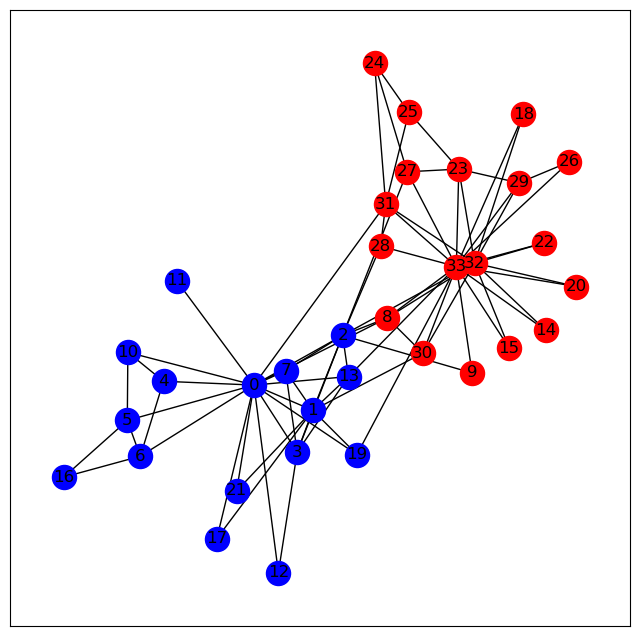

In [30]:
plt.figure(figsize=(8,8))
pos = nx.spring_layout(g_karate, seed =123)
nx.draw_networkx_nodes(g_karate, pos=pos, nodelist=list(nodes_cluster_1), node_color="blue")
nx.draw_networkx_nodes(g_karate, pos=pos, nodelist=list(nodes_cluster_2), node_color="red")
nx.draw_networkx_labels(g_karate, pos=pos)
nx.draw_networkx_edges(g_karate, pos=pos)

## 4.2 Network Algorithms



In opposition to machine learning methods we can find network algorithms. These do not transform the graph into an embedding, to then run traditional machine learning algorithms (like KMeans clustering). Rather they work with the existing graph and its properties to find clusters. 

Here we will present two such algorithms: the Girvan-Newman algorithm and Louvain Communities. Other such algorithms exist, but are not covered in this work.

### A. Girvan-Newman

The Girvan-Newman method (Girvan and Newman, 2002) for partitioning of communities depends on the edge-betweeness property. We have covered node-betweeness in Chapter 3. Node measures how many shortest paths between nodes v and w pass through a given node n. Edge betweeness measures the same property, but for edges instead of nodes. 

We can calculate edge betweeness using the edge_betweeness_centrality function in networkx. This will provide a list of all the edges present in the network, with their centrality score as we can see below:

In [53]:
edges = nx.edge_betweenness_centrality(g_karate).keys()
scores = nx.edge_betweenness_centrality(g_karate).values()

In [56]:
pd.DataFrame({"edges":edges, "scores":scores}).sort_values("scores", ascending=False)

,edges,scores
15,"(0, 31)",0.127260
5,"(0, 6)",0.078134
4,"(0, 5)",0.078134
1,"(0, 2)",0.077788
7,"(0, 8)",0.074240
...,...,...
66,"(26, 29)",0.004533
62,"(24, 25)",0.004219
32,"(3, 7)",0.003366
37,"(5, 6)",0.002971


We can plot the most central edge in red below

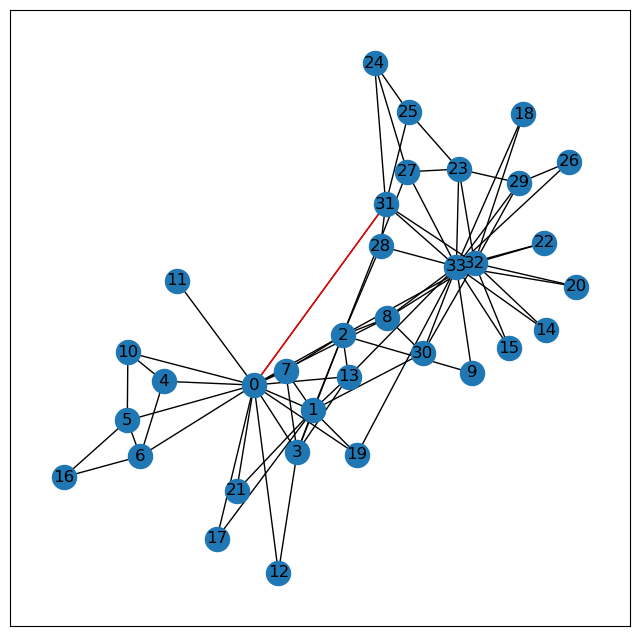

In [59]:
plt.figure(figsize=(8,8))
pos = nx.spring_layout(g_karate, seed =123)
nx.draw_networkx_nodes(g_karate, pos=pos, node_color="tab:blue")
nx.draw_networkx_labels(g_karate, pos=pos)
nx.draw_networkx_edges(g_karate, pos=pos)
nx.draw_networkx_edges(g_karate, pos=pos, edgelist=[(0,31)], edge_color="red")

What the Girvan Newman algorithm does, is it progressively removes the edge with the highest betweeness centrality score, this will progressively break down the graph, creating distinct communities. Every new iteration in the process, the betweenness centrality for edges is recalculated. This means that the calculation becomes progressively easier as more edges are removed.

In networkx this is impemented as an iterator, which can be run multiple times using the next() function, each time taking one step further, in this case, each time removing one more edge. The results are shown below:

In [60]:
gn_iterator = nx.algorithms.community.girvan_newman(g_karate)

In [61]:
gn_communities = []
for i in range(0,5):
    temp = next(gn_iterator)
    print(temp)
    gn_communities.append(temp)

({0, 1, 3, 4, 5, 6, 7, 10, 11, 12, 13, 16, 17, 19, 21}, {2, 8, 9, 14, 15, 18, 20, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33})
({0, 1, 3, 4, 5, 6, 7, 10, 11, 12, 13, 16, 17, 19, 21}, {32, 33, 2, 8, 14, 15, 18, 20, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31}, {9})
({0, 1, 3, 7, 11, 12, 13, 17, 19, 21}, {32, 33, 2, 8, 14, 15, 18, 20, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31}, {4, 5, 6, 10, 16}, {9})
({0, 1, 3, 7, 11, 12, 13, 17, 19, 21}, {2, 24, 25, 27, 28, 31}, {4, 5, 6, 10, 16}, {32, 33, 8, 14, 15, 18, 20, 22, 23, 26, 29, 30}, {9})
({0, 1, 3, 7, 12, 13, 17, 19, 21}, {2, 24, 25, 27, 28, 31}, {4, 5, 6, 10, 16}, {32, 33, 8, 14, 15, 18, 20, 22, 23, 26, 29, 30}, {9}, {11})


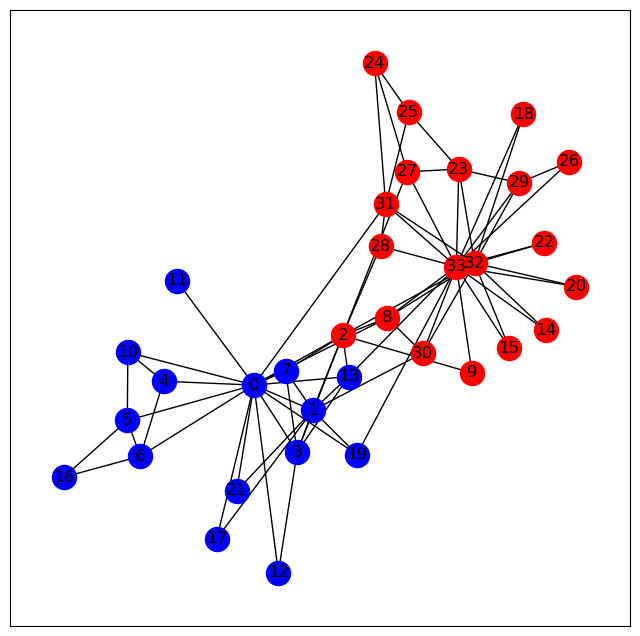

In [46]:
plt.figure(figsize=(8,8))
pos = nx.spring_layout(g_karate, seed =123)
nx.draw_networkx_nodes(g_karate, pos=pos, nodelist=list(gn_communities[0][0]), node_color="blue")
nx.draw_networkx_nodes(g_karate, pos=pos, nodelist=list(gn_communities[0][1]), node_color="red")
nx.draw_networkx_labels(g_karate, pos=pos)
nx.draw_networkx_edges(g_karate, pos=pos)

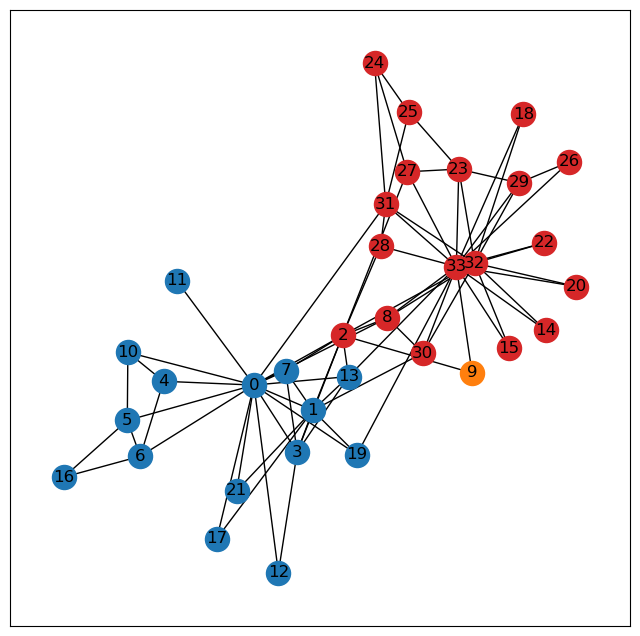

In [64]:
plt.figure(figsize=(8,8))
pos = nx.spring_layout(g_karate, seed =123)
nx.draw_networkx_nodes(g_karate, pos=pos, nodelist=list(gn_communities[1][0]), node_color="tab:blue")
nx.draw_networkx_nodes(g_karate, pos=pos, nodelist=list(gn_communities[1][1]), node_color="tab:red")
nx.draw_networkx_nodes(g_karate, pos=pos, nodelist=list(gn_communities[1][2]), node_color="tab:orange")
nx.draw_networkx_labels(g_karate, pos=pos)
nx.draw_networkx_edges(g_karate, pos=pos)

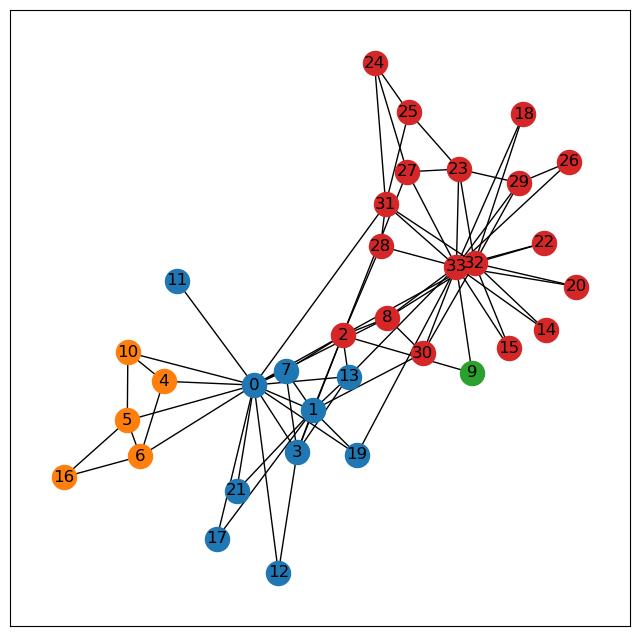

In [66]:
plt.figure(figsize=(8,8))
pos = nx.spring_layout(g_karate, seed =123)
nx.draw_networkx_nodes(g_karate, pos=pos, nodelist=list(gn_communities[2][0]), node_color="tab:blue")
nx.draw_networkx_nodes(g_karate, pos=pos, nodelist=list(gn_communities[2][1]), node_color="tab:red")
nx.draw_networkx_nodes(g_karate, pos=pos, nodelist=list(gn_communities[2][2]), node_color="tab:orange")
nx.draw_networkx_nodes(g_karate, pos=pos, nodelist=list(gn_communities[2][3]), node_color="tab:green")
nx.draw_networkx_labels(g_karate, pos=pos)
nx.draw_networkx_edges(g_karate, pos=pos)

### B. Louvain Communities

Now we will consider only the Louvain method for community detection (see Blondel, Lambiotte & Lefebvre 2008). This is an algorithm that finds communities by using the concept of modularity gain. 

In order to fully introduce this method, we first have to understand the concept of modularity.

#### Modularity

Modularity in essence compares the edges of nodes in a certain community to the edges the nodes have to nodes outside of the community. For example it may be the case that court decisions on contract law are more likely to cite one another (they will have edges to nodes within the community) than to cite court decisions on any other subject (have edges to nodes outside the community). The higher the number of edges staying within the community relative to the edges going outside, the higher the community's modularity.



The formula for modularity can be presented in a variety of ways and there are advantages to each form or presentation. Here are two formulas:

$$ Q = \frac{1}{2m}\sum_{c=1}^{n} \left[ \Sigma A_c - \gamma\frac{\Sigma D_c^2}{2m} \right] $$


$$ Q = \sum_{c=1}^{n} \left[ \frac{\Sigma A_c}{2m} - \gamma\left( \frac{\Sigma D_c}{2m} \right) ^2 \right] $$

(These formulas have been adapted from the documentation to make the notation easier to follow, especially for an attempt to put them in practice by hand.)

For our discussion we will focus on the second formula, because it most clearly shows a difference between two ratios. The representation we choose here provides the most insight into what modularity does. 

* $ \Sigma A_c $ is the sum of the adjacency matrix of the community only (no edges to nodes outside of the community) .

* $ m $ is the total number of edges of the network.

* $\Sigma D_c$ is the degree of the nodes of the community, taking into consideration their edges to nodes outside of the community.

* $\gamma$ is a dampening parameter, that for our purposes can be ignored if set to 1. Making this number smaller will make it easier to find communities, and making it larger makes communities harder to find. (!!CHECK!!)

We observe a difference between fractions. That is to say, a difference between proportions.

* $ \frac{\Sigma A_c}{2m} $ represents the proportion of purely intra-community edges for a given community to the total number of edges. The division by 2 considers the fact that the adjacency matrix will count two for every edge.

* $ \left( \frac{\Sigma D_c}{2m} \right) ^2 $ represents the proportion of the edges that a community has to nodes within and outside of itself to the total number of edges in the network.

The logic of this is that if the left hand side of the difference is greater than the right hand side of the difference one will get a positive number. And the larger the difference, the tighter a community is, the larger the number. 

* The $ \Sigma $ is a summation notation that states that the difference between fractions will be repeated for every hypothesized community and added up. The higher the ultimate summation, the better the community partition is.

We can operationalize the formula "by hand" on the graph of Florentine families hypothesizing that the families Castellani, Peruzzi and Strozzi form a community vis-a-vis the rest of the other families. A quick look at the graphs suggest that this is a reasonable grouping.

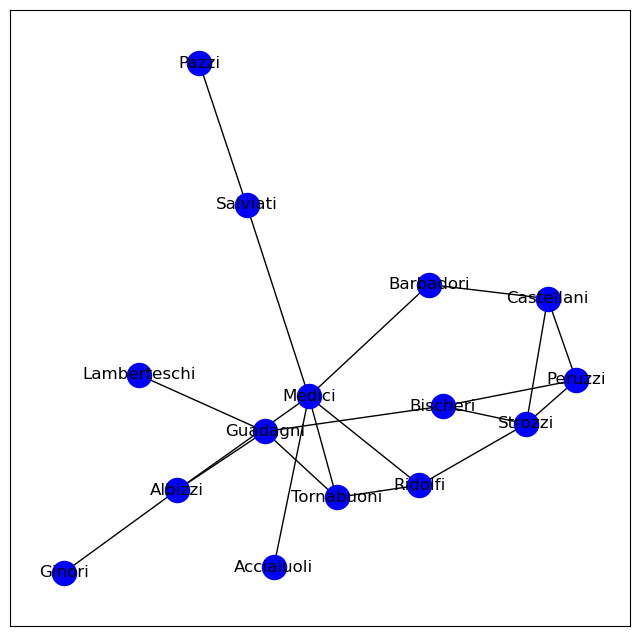

In [80]:
g_florentine = nx.florentine_families_graph()
draw_spring(g_florentine)

First let us save two lists with the names of the nodes that we want to use as hypothesized communities. Castellani, Peruzzi and Strozzi in one list, the rest on the other.

In [81]:
fl_CPS = ['Castellani','Peruzzi','Strozzi']
fl_other= ['Acciaiuoli', 'Medici', 'Barbadori', 'Ridolfi', 'Tornabuoni', 'Albizzi', 'Salviati', 'Pazzi', 'Bischeri', 'Guadagni', 'Ginori', 'Lamberteschi']

Since m is just the number of edges we can obtain the number in this manner.

In [82]:
m = len(g_florentine.edges)
m

20

For $\Sigma A_c $ we need to get the adjacency matrix of just the nodes within the community. This means we need to sever the connection of the community with other nodes. We can get this with the subgraph function.

In [83]:
sub_fl_CPS = g_florentine.subgraph(fl_CPS)
sub_fl_other = g_florentine.subgraph(fl_other)

Now we can get the adjacency matrix of the subgraphs like this...

In [84]:
nx.adjacency_matrix(sub_fl_CPS).todense()

array([[0, 1, 1],
       [1, 0, 1],
       [1, 1, 0]])

Numpy can sum all the values of such matrices with a call to np.sum.

In [85]:
SA_cps = np.sum(nx.adjacency_matrix(sub_fl_CPS).todense())
SA_other = np.sum(nx.adjacency_matrix(sub_fl_other).todense())
print(f"the value of SigmaA_c for the CPS community is {SA_cps} and for the other is {SA_other}")

the value of SigmaA_c for the CPS community is 6 and for the other is 26


This gets us all we need for the left hand side of the difference.

Now we move to work on the right side of the difference. The value of $ \Sigma D_c $ is the sum of the degree of the nodes that interest us, but not with their values cut off from the network -that is, not as subgraphs- but in their full values connected to the Florentine families network. 

In terms of code it can be slightly tricky to unpack these values. Below we use a np.sum over a list comprehension that produces the degree scores of only the nodes we need.

In [86]:
SD_cps = np.sum([x[1] for x in list(nx.degree(g_florentine, fl_CPS))])

SD_other = np.sum([x[1] for x in list(nx.degree(g_florentine, fl_other))])

print(f"the value of SigmaD_c for the CPS community is {SD_cps} and for the other is {SD_other}")

the value of SigmaD_c for the CPS community is 10 and for the other is 30


Now we are ready to fill in the blanks. Remember the formula is:

$$ Q = \sum_{c=1}^{n} \left[ \frac{\Sigma A_c}{2m} - \gamma\left( \frac{\Sigma D_c}{2m} \right) ^2 \right] $$

So for the first community we have

$$ CPS =\left[ \frac{6}{40} - \gamma\left( \frac{10}{40} \right) ^2 \right] = 0.875 $$

In [87]:
CPS_result = (SA_cps/(2*m)) - ((SD_cps/(2*m))**2)
CPS_result

0.0875

And for the second 

$$ other = \left[ \frac{26}{40} - \gamma\left( \frac{30}{40} \right) ^2 \right] = 0.875 $$

In [88]:
other_result = (SA_other/(2*m)) - ((SD_other/(2*m))**2)
other_result

0.08750000000000002

And adding them together we get 0.175

In [89]:
CPS_result + other_result

0.17500000000000002

 Which is the same as the official result.

In [90]:
nx.algorithms.community.modularity(g_florentine, [fl_CPS, fl_other])

0.17500000000000002

Thus the following partition has the positive modularity score of 0.175.

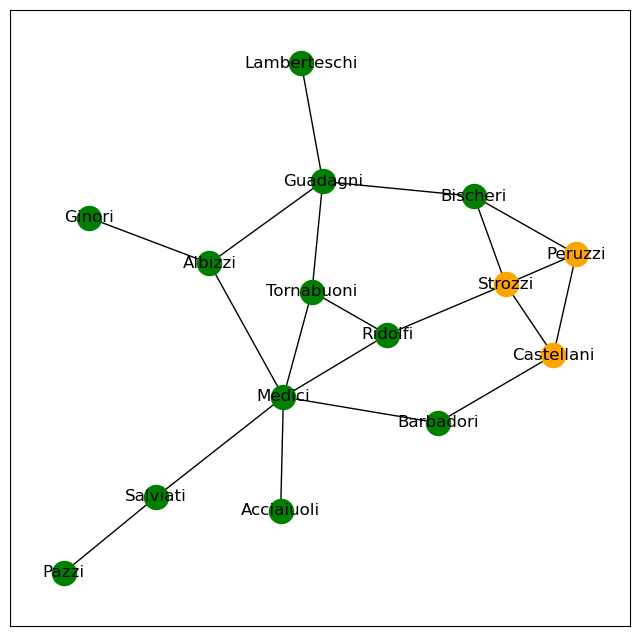

In [91]:
plt.figure(figsize=(8,8))
pos = nx.spring_layout(g_florentine)
nx.draw_networkx_nodes(g_florentine, pos, nodelist=fl_CPS, node_color='orange')
nx.draw_networkx_nodes(g_florentine, pos, nodelist=fl_other, node_color='green')
nx.draw_networkx_edges(g_florentine, pos=pos)
nx.draw_networkx_labels(g_florentine, pos=pos);

#### The Louvain Communities Algorithm

What Louvain community detection does, is to try to find the distribution of communities that will give the highest modularity score, using a sort of cumulative random search.

1. It will asume every node is a community and score the modularity.
2. It will assign every node to a community with one of its neighbors and score the modularity of the result.
3. It will keep the assignment that gives the highest modularity score.
4. The resulting communities will be treated as nodes.
5. Step 1 is repeated.

This process keeps going until there is no more modularity gain.

We can quickly try to run the Louvain communities algorithm to find the best partition of the Florentine families network that we used earlier to discuss modularity.
It turns out the best split is in four communities. Compared to our intuitive results presented above, we can see that Castellani, Peruzzi and Strozzi did deserve to go together, but that Bischeri should have been also part their team.

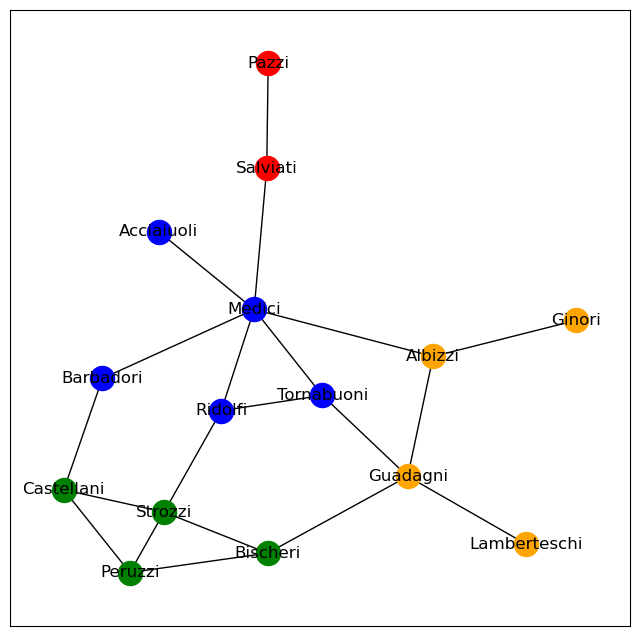

In [92]:
plt.figure(figsize=(8,8))
result = nx.algorithms.community.louvain_communities(g_florentine)
pos = nx.spring_layout(g_florentine)
nx.draw_networkx_nodes(g_florentine, pos, nodelist=result[0], node_color='blue')
nx.draw_networkx_nodes(g_florentine, pos, nodelist=result[1], node_color='red')
nx.draw_networkx_nodes(g_florentine, pos, nodelist=result[2], node_color='green')
nx.draw_networkx_nodes(g_florentine, pos, nodelist=result[3], node_color='orange')
nx.draw_networkx_edges(g_florentine, pos=pos)
nx.draw_networkx_labels(g_florentine, pos=pos);

Now let us calculate the modularity score for the Louvain-detected communities. We can see that at 0.3975 it is quite a bit higher than our intuitive partition.

In [93]:
nx.algorithms.community.modularity(g_florentine, result)

0.39749999999999996

We now try to approximate this by hand. Let us see how far we can get. We will use a smaller graph, the kite, to make our life easier. There are key differences between what we are doing and the actual Louvain Communities algorithm. However, this will be enough for us to get an idea of what is going on.

The question is how to best partition the kite in terms of modularity.

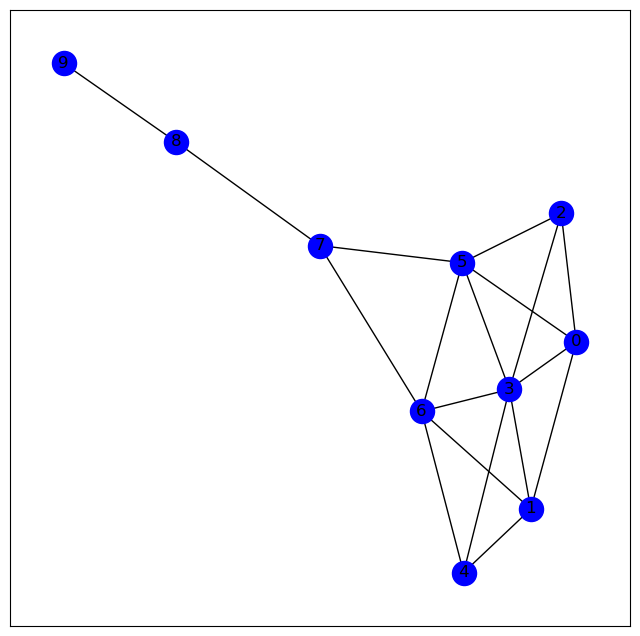

In [94]:
g_kite = nx.krackhardt_kite_graph()
draw_spring(g_kite)

Doing a pseudo-Louvain process, We begin by assigning each node in the kite graph to its own community. Since this is a very bad partition, it makes sense that we get a negative modularity score.

In [95]:
nx.algorithms.community.modularity(g_kite, [[x] for x in range(0,10)])

-0.11574074074074076

Now we will assign each node, to one of its neighbors, and obtain the modularity score.

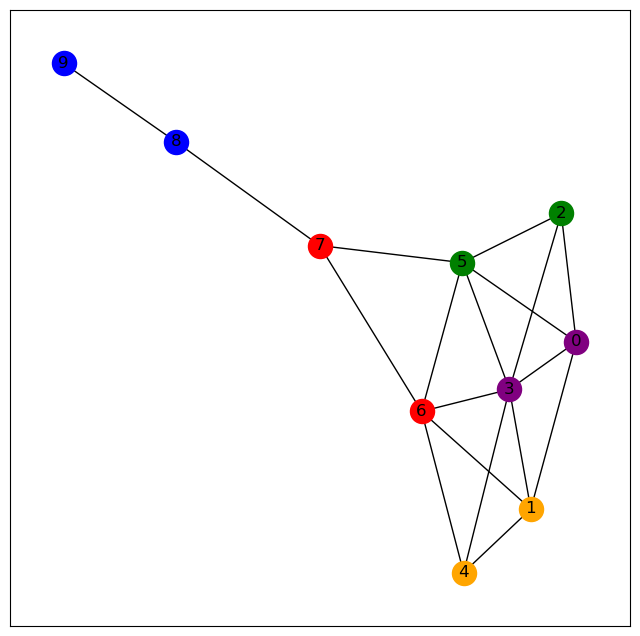

In [96]:
plt.figure(figsize=(8,8))
pos = nx.spring_layout(g_kite, seed=123)
nx.draw_networkx_nodes(g_kite, pos, nodelist=[9,8], node_color='blue')
nx.draw_networkx_nodes(g_kite, pos, nodelist=[7,6], node_color='red')
nx.draw_networkx_nodes(g_kite, pos, nodelist=[5,2], node_color='green')
nx.draw_networkx_nodes(g_kite, pos, nodelist=[4,1], node_color='orange')
nx.draw_networkx_nodes(g_kite, pos, nodelist=[3,0], node_color='purple')
nx.draw_networkx_edges(g_kite, pos=pos)
nx.draw_networkx_labels(g_kite, pos=pos);

In [97]:
nx.algorithms.community.modularity(g_kite, [[9,8], [7,6], [5,2],[4,1],[3,0]])

0.057098765432098755

Then we could keep assigning nodes and see an increase.

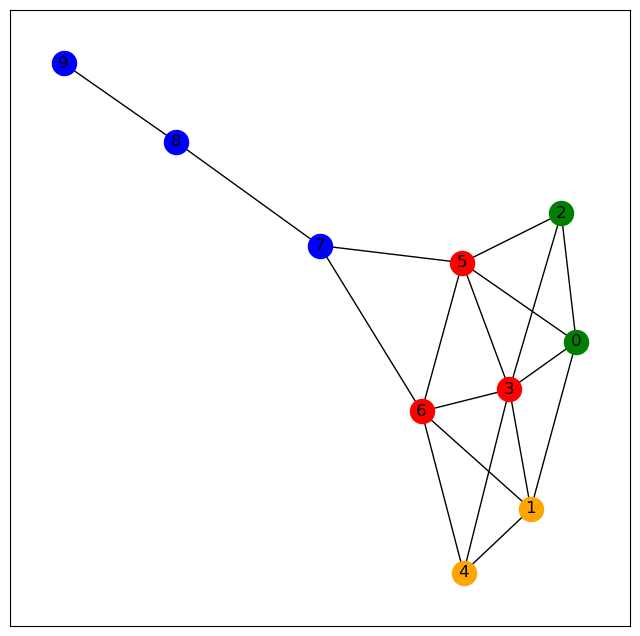

In [98]:
plt.figure(figsize=(8,8))
pos = nx.spring_layout(g_kite, seed=123)
nx.draw_networkx_nodes(g_kite, pos, nodelist=[9,8,7], node_color='blue')
nx.draw_networkx_nodes(g_kite, pos, nodelist=[6,5,3], node_color='red')
nx.draw_networkx_nodes(g_kite, pos, nodelist=[2,0], node_color='green')
nx.draw_networkx_nodes(g_kite, pos, nodelist=[4,1], node_color='orange')
nx.draw_networkx_edges(g_kite, pos=pos)
nx.draw_networkx_labels(g_kite, pos=pos);

In [99]:
nx.algorithms.community.modularity(g_kite, [[9,8,7], [6,5,3], [2,0],[4,1]])

0.08796296296296295

But not every reassignment is going to be an increase. If we extend the first cluster, we will get a decrease in modularity.

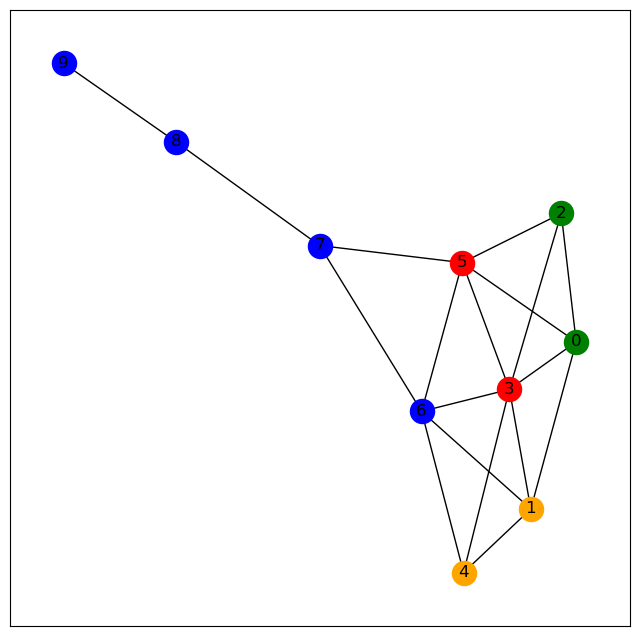

In [100]:
plt.figure(figsize=(8,8))
pos = nx.spring_layout(g_kite, seed=123)
nx.draw_networkx_nodes(g_kite, pos, nodelist=[9,8,7, 6], node_color='blue')
nx.draw_networkx_nodes(g_kite, pos, nodelist=[5,3], node_color='red')
nx.draw_networkx_nodes(g_kite, pos, nodelist=[2,0], node_color='green')
nx.draw_networkx_nodes(g_kite, pos, nodelist=[4,1], node_color='orange')
nx.draw_networkx_edges(g_kite, pos=pos)
nx.draw_networkx_labels(g_kite, pos=pos);

In [101]:
nx.algorithms.community.modularity(g_kite, [[9,8,7, 6], [5,3], [2,0],[4,1]])

0.07098765432098764

Our pseudo-Louvain algorithm would therefore stop short of that last assignment. The real Louvain method would do this in an mechanical, incremental fashion until the communities with very good modularity scores are found. The algorithm has elements of randomness, so it is not guaranteed to achieve the best result, or the same result every time it is run.

A difference of note is that instead of incrementally linking up the nodes of the kite, what are the communities at the first level will be turned into nodes at the second level. (!!add photo from louvain to leuven article!!). 

What this means in practice, is that unlike what we are doing, the algorithm does not focus on modularity per se, but on modularity gain. That is, it focuses on the difference in modularity between one partitioning and another. It does not really look for the highest modularity value, but instead keeps going while it finds positive modularity gain, or until modularity gains are so small that they fall below a specified margin.

Happily, the formula for modularity gain is not so different from that of modularity

$$ \Delta Q = \left[ \frac{\Sigma A_c + K_{in}}{2m} - \frac{\Sigma D_c + K_{in}}{2m} \right] - \left[\frac{\Sigma A_c}{2m}-\frac{\Sigma D_c}{2m} - \frac{K_in}{2m}  \right]   $$

In fact it is the ratio of two modulary scores. One (the left brackets) is the score with the node K inserted into it and the the other (the right bracket) is the score with the node K removed from it. It is added on the left and removed on the right to represent the delta, or the difference in modularity, when one community gains a node and another one loses it.

With our pseudo-Louvain approach we did not did do the best possible combination, but with the real Louvain communities algorithm we can see what the better partition would be:

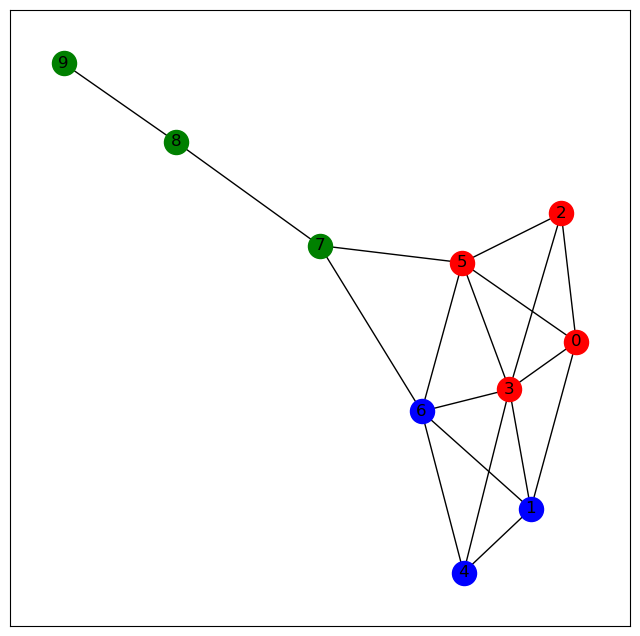

In [102]:
plt.figure(figsize=(8,8))
pos = nx.spring_layout(g_kite, seed=123)
result = nx.algorithms.community.louvain_communities(g_kite)
nx.draw_networkx_nodes(g_kite, pos, nodelist=result[0], node_color='blue')
nx.draw_networkx_nodes(g_kite, pos, nodelist=result[1], node_color='red')
nx.draw_networkx_nodes(g_kite, pos, nodelist=result[2], node_color='green')
nx.draw_networkx_edges(g_kite, pos=pos)
nx.draw_networkx_labels(g_kite, pos=pos);

We can do the same for the subgraph of the CJEU case law example. We first calculate the number of communities:

In [103]:
g_consprot2 = load_graph_from_json("data/g_consprot2.json")
communities = sorted(nx.algorithms.community.greedy_modularity_communities(g_consprot2), key=len, reverse=True)
print(f"The network has {len(communities)} communities.")

The network has 13 communities.


We subsequently plot assign each node to a community and visualize the communities in the network.

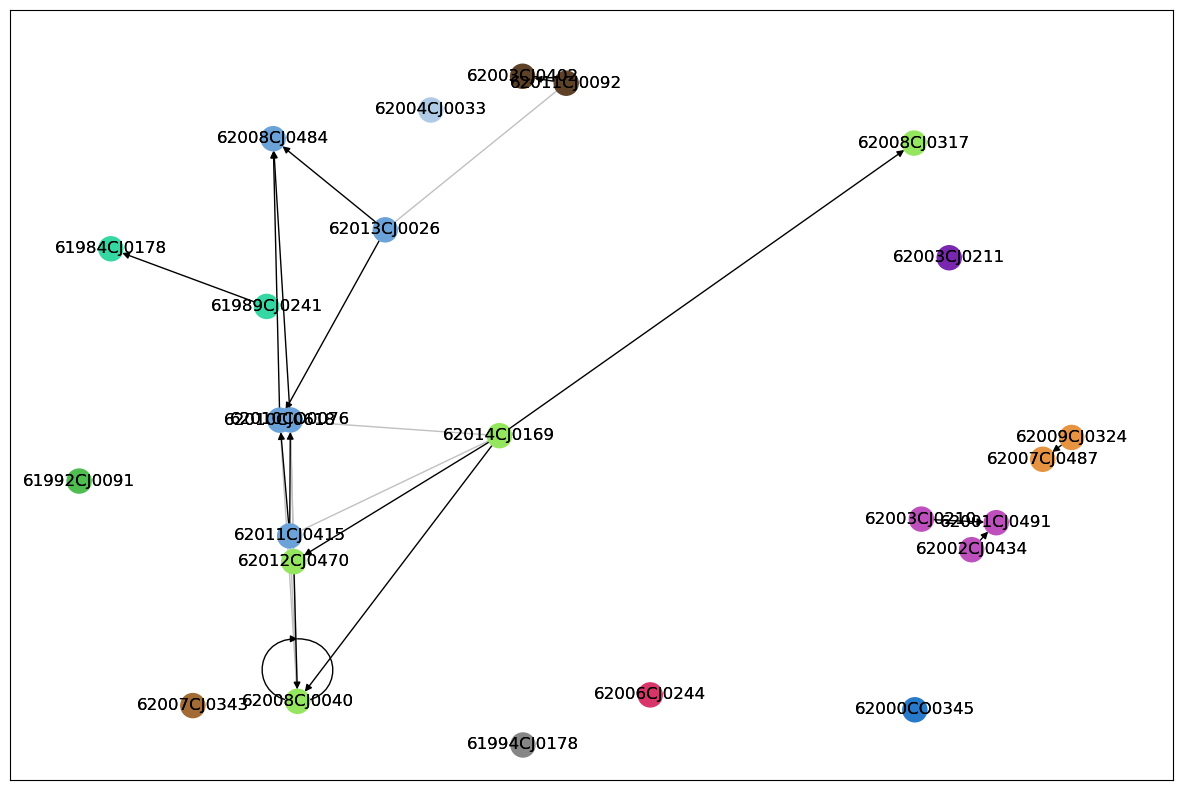

In [104]:

def set_node_community(G, communities):
    '''Add community to node attributes'''
    for c, v_c in enumerate(communities):
        for v in v_c:
            # Add 1 to save 0 for external edges
            G.nodes[v]['community'] = c + 1
def set_edge_community(G):
    '''Find internal edges and add their community to their attributes'''
    for v, w, in G.edges:
        if G.nodes[v]['community'] == G.nodes[w]['community']:
            # Internal edge, mark with community
            G.edges[v, w]['community'] = G.nodes[v]['community']
        else:
            # External edge, mark as 0
            G.edges[v, w]['community'] = 0
def get_color(i, r_off=1, g_off=1, b_off=1):
    '''Assign a color to a vertex.'''
    r0, g0, b0 = 0, 0, 0
    n = 16
    low, high = 0.1, 0.9
    span = high - low
    r = low + span * (((i + r_off) * 3) % n) / (n - 1)
    g = low + span * (((i + g_off) * 5) % n) / (n - 1)
    b = low + span * (((i + b_off) * 7) % n) / (n - 1)
    return (r, g, b)

# Set node and edge communities
set_node_community(g_consprot2, communities)
set_edge_community(g_consprot2)
node_color = [get_color(g_consprot2.nodes[v]['community']) for v in g_consprot2.nodes]
# Set community color for edges between members of the same community (internal) and intra-community edges (external)
external = [(v, w) for v, w in g_consprot2.edges if g_consprot2.edges[v, w]['community'] == 0]
internal = [(v, w) for v, w in g_consprot2.edges if g_consprot2.edges[v, w]['community'] > 0]
internal_color = ['black' for e in internal]

# Set node and edge communities
set_node_community(g_consprot2, communities)
set_edge_community(g_consprot2)
node_color = [get_color(g_consprot2.nodes[v]['community']) for v in g_consprot2.nodes]
# Set community color for edges between members of the same community (internal) and intra-community edges (external)
external = [(v, w) for v, w in g_consprot2.edges if g_consprot2.edges[v, w]['community'] == 0]
internal = [(v, w) for v, w in g_consprot2.edges if g_consprot2.edges[v, w]['community'] > 0]
internal_color = ['black' for e in internal]

g_consprot2_pos = nx.spring_layout(g_consprot2)
plt.rcParams.update({'figure.figsize': (15, 10)})
# Draw external edges
nx.draw_networkx(
    g_consprot2,
    pos=g_consprot2_pos,
    node_size=0,
    edgelist=external,
    edge_color="silver")
# Draw nodes and internal edges
nx.draw_networkx(
    g_consprot2,
    pos=g_consprot2_pos,
    node_color=node_color,
    edgelist=internal,
    edge_color=internal_color)
plt.show()

## 4.3 Centrality of communities

Once a community has been found, it is possible to submit that community to forms of analysis that were first applied to the whole graph. Naturally results will change when we only consider the smaller community.

In NetworkX this is done using the ````subgraph```` function, passing in the node list of the selected community. 

Here we will consider the community that centers around the President of the Karate Club which appears in red below.

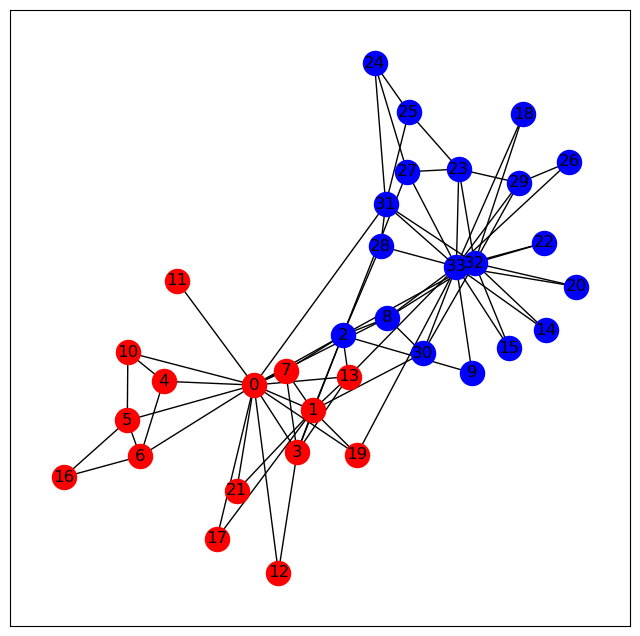

In [105]:
plt.figure(figsize=(8,8))
pos = nx.spring_layout(g_karate, seed =123)
nx.draw_networkx_nodes(g_karate, pos=pos, nodelist=list(nodes_cluster_1), node_color="blue")
nx.draw_networkx_nodes(g_karate, pos=pos, nodelist=list(nodes_cluster_2), node_color="red")
nx.draw_networkx_labels(g_karate, pos=pos)
nx.draw_networkx_edges(g_karate, pos=pos)

If we see the closeness centrality scores

In [109]:
karate_closeness = pd.DataFrame({"nodes":nx.closeness_centrality(g_karate).keys(), "centrality":nx.closeness_centrality(g_karate).values()})\
.sort_values("centrality", ascending=False)\
.head(10)
karate_closeness


,nodes,centrality
0,0,0.568966
2,2,0.559322
33,33,0.550000
31,31,0.540984
13,13,0.515625
32,32,0.515625
8,8,0.515625
19,19,0.500000
1,1,0.485294
3,3,0.464789


Here we can see that the top performers include naturally the President at node 0, the Karate instructor who is node 33 and node 13 does pretty well being in the 5th spot.

However if we consider only the subgraph of the supporters of the President, the network metrics change, including the centrality ranking.

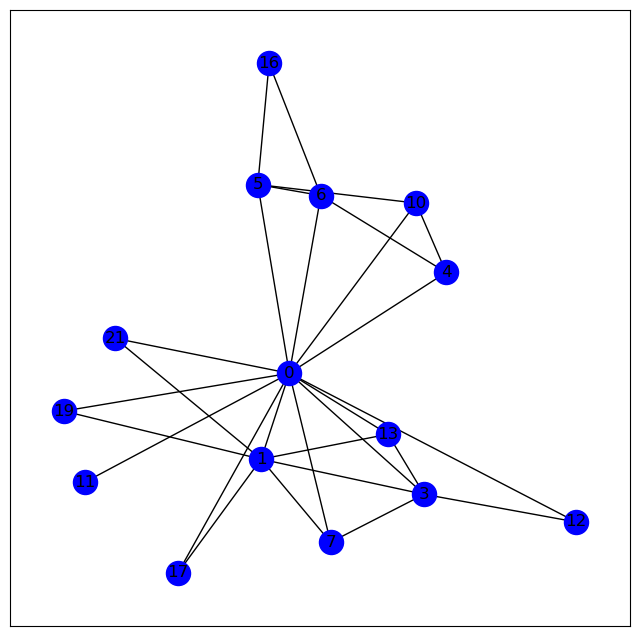

In [112]:
g_subkarate = nx.subgraph(g_karate, nodes_cluster_2)
draw_spring(g_subkarate)

In [111]:
pd.DataFrame({"nodes":nx.closeness_centrality(g_subkarate).keys(), "centrality":nx.closeness_centrality(g_subkarate).values()})\
.sort_values("centrality", ascending=False)\
.head(10)

,nodes,centrality
0,0,0.933333
1,1,0.636364
2,3,0.583333
4,5,0.583333
5,6,0.583333
3,4,0.560000
7,10,0.560000
6,7,0.538462
10,13,0.538462
9,12,0.518519


Node 13 is no longer as important now that his friends with the faction of the instructor are factored out. By contrast node 1 rises in prominence from position 9 to second place.

This analysis is only schematic, but it shows that identifying communities can be an important step for getting more finely grained network metrics.